# Intro

This notebook analyzes data from [JTPL](https://jefflibrary.org)'s [hoopla](https://hoopladigital.com) subscription for the period the library was closed to the public due to COVID-19. 

While the official dates of library closure were March 18 - June 14, 2020, to be able to make more accurate statistical comparisons I'm working with data from **March 1 - June 30, 2020**.

-----

# Initial Setup

Importing modules and cleaning data

In [1]:
# Initial setup
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import table

In [2]:
# Import CSV of circulation data by format
circs = pd.read_csv('data/Hoopla/Hoopla-CircsByMonth-2020_03-2020_06.csv')

In [3]:
# Drop extraneous columns and rename headers
new_circs = circs.drop([
    'audiobook cost', 
    'comic cost', 
    'ebook cost', 
    'movie cost', 
    'music cost', 
    'television cost', 
    'total circulations', 
    'total cost'
], axis=1)

new_circs = new_circs.rename(columns={
    "date": "Month",
    "audiobook circulations": "Audiobooks", 
    "comic circulations": "Comics", 
    "ebook circulations": "eBooks", 
    "movie circulations": "Movies", 
    "music circulations": "Music", 
    "television circulations": "TV Shows"
}).set_index("Month")

--- 

# Circulation Trends

We'll start with a recap of basic stats about circulation by format for this 4 month period, and then show a few graphs of different visualizations of that data.

In [4]:
# View the clean dataframe & highlight max value for each format
new_circs.style.highlight_max(axis=0)

,Audiobooks,Comics,eBooks,Movies,Music,TV Shows
Month,,,,,,
March 2020,409,37,184,72,27,45
April 2020,419,45,213,95,23,37
May 2020,421,39,228,61,28,33
June 2020,386,47,218,91,26,28


In [5]:
# get total circs for each format
sum_format = new_circs.sum(axis=0)
print(f"Total Circulations by Format:\n\n{sum_format}")

Total Circulations by Format:

Audiobooks    1635
Comics         168
eBooks         843
Movies         319
Music          104
TV Shows       143
dtype: int64


In [6]:
#get total circs by month
sum_month = new_circs.sum(axis=1)
print(f"Total Circulations by Month:\n\n{sum_month}")


Total Circulations by Month:

Month
March 2020    774
April 2020    832
May 2020      810
June 2020     796
dtype: int64


## Visualization of Circulation Data

Generating data visualizations for the circulation data using the standard pandas plotting library, which is built on matplotlib.

### Stacked Bar Chart

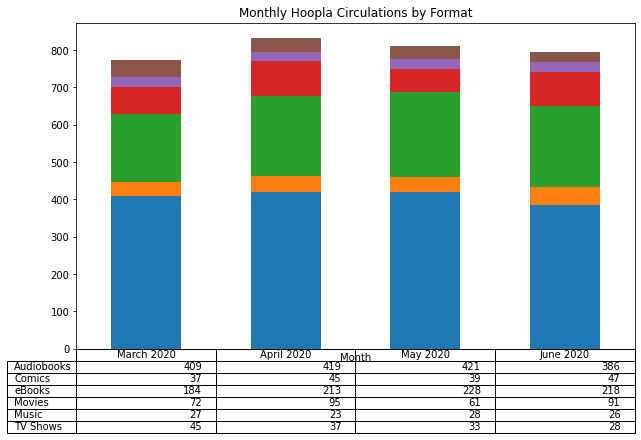

In [7]:
new_circs.plot(kind='bar', table=True, figsize=(10,6), stacked=True, legend=False, title="Monthly Hoopla Circulations by Format", xticks=[]);

## Pie Charts By Month

In order to view monthly pie charts, we first need to transpose the dataframe and do a little bit more renaming.

In [8]:
new_circs.index = new_circs.index.set_names('Format')
flopped = new_circs.T
flopped = flopped.rename(columns={"Mar 2020": "March 2020", "Apr 2020": "April 2020", "Jun 2020": "June 2020"})

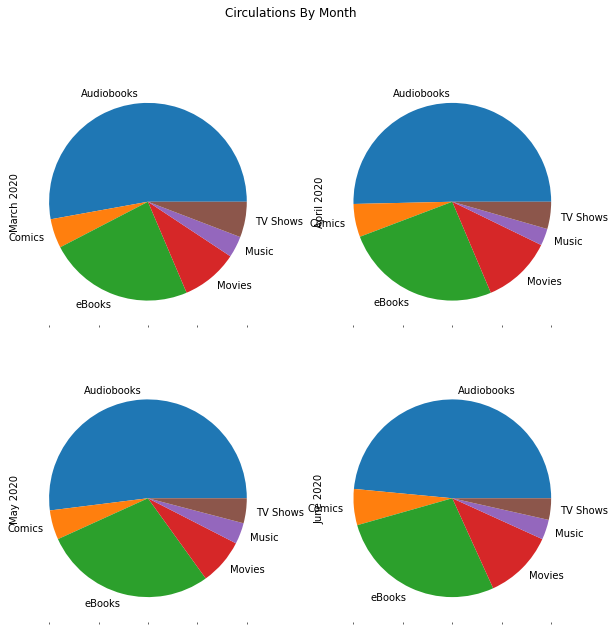

In [9]:
flopped.plot(kind='pie', subplots=True, layout=(2,2), figsize=(10, 10), legend=False, title="Circulations By Month", xticks=[], yticks=[]);

In [1]:
#new_circs.plot(kind='pie', subplots=True, layout=(2,3), figsize=(10, 10), legend=False, title="Circulations By Format", xticks=[], yticks=[]);

---

# Popular Titles

After looking at what formats were generally most popular, we'll now take a look at the actual titles that were most popular.

## Title-level Setup

In [11]:
# create a dataframe for the CSV containing all titles checked out for a given month
mar_titles = pd.read_csv('data/Hoopla/Hoopla-TopTitles-2020_03.csv')
apr_titles = pd.read_csv('data/Hoopla/Hoopla-TopTitles-2020_04.csv')
may_titles = pd.read_csv('data/Hoopla/Hoopla-TopTitles-2020_05.csv')
jun_titles = pd.read_csv('data/Hoopla/Hoopla-TopTitles-2020_06.csv')

In [12]:
# Function to create a new pop_titles dataframe (with a new column for month name) for each CSV file
def pop_titles(month_file, month_name):   
    
    month_length = len(month_file.index)
    
    # create a list that repeats the month name + year 
    month_list = [month_name for _ in range(0, month_length)]
    
    # add this list of month names as a new column to the original dataframe
    month_file['Month'] = month_list
    
    # select only titles that circulated at least twice
    over_one = month_file['circs']>1
    new_df = month_file[over_one].drop(['rank', 'isbn', 'parentalAdvisory', 'rating', 'kids mode'], axis=1)
    new_df[['titleTitle','genres']] = new_df[['titleTitle','genres']].fillna('')
    new_df[['price']] = new_df[['price']].fillna('0.00')
    
    # return all the titles that circ'd 2+ times but drop unnecessary columns
    return new_df

In [13]:
# create smaller dataframes of titles that circ'd at least 2x
mar_pop_titles = pop_titles(mar_titles, "March 2020")
apr_pop_titles = pop_titles(apr_titles, "April 2020")
may_pop_titles = pop_titles(may_titles, "May 2020")
jun_pop_titles = pop_titles(jun_titles, "June 2020")

In [14]:
# combine above dataframes into one big dataframe covering the entire period
df = pd.concat([mar_pop_titles, apr_pop_titles, may_pop_titles, jun_pop_titles], axis=0)

In [15]:
# use groupby to sum circulation amounts for the same title that circulated multiple months, then sort descending by circs
def get_grouped(TV=False):
    if TV:
        grouped = df.groupby(['title', 'titleTitle', 'primaryPerson', 'kind', 'year', 'genres'])[['circs']].sum().reset_index()
    else:
        grouped = df.groupby(['title', 'primaryPerson', 'kind', 'year', 'genres'])[['circs']].sum().reset_index()
        
    grouped = grouped.sort_values(by='circs', ascending=False)
    return grouped


In [24]:
# Function to generate top 10 lists
def gen_top_ten(format):
    if str(format) == 'TELEVISION':
        grouped = get_grouped(TV=True)
    else:
        grouped = get_grouped()
        
    top_format = grouped.loc[grouped['kind'] == format].sort_values(by='circs', ascending=False).reset_index(drop=True)
    top_format.index = top_format.index + 1
    
    return top_format.head(10)

## Top 10 Lists

Because some formats, like comics, aren't as popular as others, like audiobooks, several categories didn't have enough individual titles to create whole "Top 10" lists. For those sections I've indicated why I think we had those results.

### Top 10 Overall Titles

Lists the top 10 individual titles circulated in the period March-June 2020

In [40]:
# print top 10 most popular titles, renumbering index to start at 1
top_ten = get_grouped(True).head(10)
top_ten = top_ten.reset_index(drop=True)
top_ten.index = top_ten.index + 1
top_ten.style.set_caption('Top 10 Overall Titles')


Top 10 Overall Titles


,title,titleTitle,primaryPerson,kind,year,genres,circs
1,The Ballad of Songbirds and Snakes,,Suzanne Collins,AUDIOBOOK,2020,"Children's, Sci-Fi & Fantasy",11
2,Unfu*k Yourself,,Gary John Bishop,AUDIOBOOK,2017,Self Help,7
3,The Keeper of Lost Things,,Ruth Hogan,EBOOK,2017,"Fiction, Literary, Magical Realism, Women",6
4,Harry Potter and the Sorcerer's Stone,,J. K. Rowling,AUDIOBOOK,2015,"Children's, Sci-Fi & Fantasy",6
5,The Hunger Games (Special Edition),,Suzanne Collins,AUDIOBOOK,2018,Teen,6
6,So You Want to Talk about Race,,Ijeoma Oluo,AUDIOBOOK,2018,Nonfiction,5
7,Don't Let The Pigeon Stay Up Late,,Mo Willems,MOVIE,2011,Children's,5
8,Color Out of Space,,Nicolas Cage,MOVIE,2020,Sci-Fi & Fantasy,5
9,The Screwtape Letters,,C. S. Lewis,AUDIOBOOK,2012,Christian Non-Fiction,5
10,Then She Was Gone,,Lisa Jewell,AUDIOBOOK,2018,Fiction,5


### Top 10 Audiobooks

In [26]:
top_audio = gen_top_ten('AUDIOBOOK')
top_audio

,title,primaryPerson,kind,year,genres,circs
1,The Ballad of Songbirds and Snakes,Suzanne Collins,AUDIOBOOK,2020,"Children's, Sci-Fi & Fantasy",11
2,Unfu*k Yourself,Gary John Bishop,AUDIOBOOK,2017,Self Help,7
3,Harry Potter and the Sorcerer's Stone,J. K. Rowling,AUDIOBOOK,2015,"Children's, Sci-Fi & Fantasy",6
4,The Hunger Games (Special Edition),Suzanne Collins,AUDIOBOOK,2018,Teen,6
5,So You Want to Talk about Race,Ijeoma Oluo,AUDIOBOOK,2018,Nonfiction,5
6,The Screwtape Letters,C. S. Lewis,AUDIOBOOK,2012,Christian Non-Fiction,5
7,Then She Was Gone,Lisa Jewell,AUDIOBOOK,2018,Fiction,5
8,Pete the Cat and the Missing Cupcakes,James Dean,AUDIOBOOK,2016,"Children's, Fiction",4
9,The Daughter In Law,Nina Manning,AUDIOBOOK,2019,Mystery,4
10,Before 1776: Life in the American Colonies,Robert J. Allison,AUDIOBOOK,2009,History,4


### Top 10 eBooks

In [28]:
top_ebooks = gen_top_ten('EBOOK')
top_ebooks

,title,primaryPerson,kind,year,genres,circs
1,The Keeper of Lost Things,Ruth Hogan,EBOOK,2017,"Fiction, Literary, Magical Realism, Women",6
2,Twisting the Truth Participant's Guide,Andy Stanley,EBOOK,2009,"Adult, Christian Education, Religion",5
3,The Engineer's Wife,Tracey Enerson Wood,EBOOK,2020,"Biographical, Fiction, Historical, Literary, W...",5
4,Lies My Teacher Told Me,James W. Loewen,EBOOK,2018,"Education, History, History, United States",4
5,Wrecking Ball,Jeff Kinney,EBOOK,2019,"Comics & Graphic Novels, Humorous Stories, Juv...",4
6,Dinosaur World,William Potter,EBOOK,2018,"Games & Activities, Juvenile Nonfiction, Puzzles",4
7,The Yellow House,Sarah M. Broom,EBOOK,2019,"Biography & Autobiography, Personal Memoirs",4
8,The Woman in the Window,A. J. Finn,EBOOK,2018,"Crime, Fiction, Psychological, Suspense, Thril...",4
9,Paradise Valley,Robyn Carr,EBOOK,2014,"Contemporary, Fiction, Romance",2
10,A Virgin River Christmas,Robyn Carr,EBOOK,2018,"Contemporary, Fiction, Holiday, Romance, Small...",2


### Top 10 Movies

In [29]:
top_movies = gen_top_ten('MOVIE')
top_movies

,title,primaryPerson,kind,year,genres,circs
1,Don't Let The Pigeon Stay Up Late,Mo Willems,MOVIE,2011,Children's,5
2,The Sea of Trees,Matthew McConaughey,MOVIE,2016,"Drama, Suspense / Thriller",5
3,Color Out of Space,Nicolas Cage,MOVIE,2020,Sci-Fi & Fantasy,5
4,The Louvre,Sidney Carroll,MOVIE,1978,"Award Winning, Documentary",4
5,Northanger Abbey,Felicity Jones,MOVIE,2008,"Drama, Romance, Romantic",3
6,Living on One Dollar,Chris Temple,MOVIE,2013,,3
7,Just Mercy,Michael B. Jordan,MOVIE,2019,Drama,3
8,The Longest Week,Jason Bateman,MOVIE,2013,,3
9,Duckling Gets a Cookie!?,Mo Willems,MOVIE,2014,"Children's, Comedy",3
10,What We Do in the Shadows,Jemaine Clement,MOVIE,2015,Comedy,3


## Top *X* Lists

For the other 3 formats, we didn't have enough individual titles circulate at least 2x to compile a top 10 list for each. 

### Top *6* Comics

Only 6 individual comic titles circulated more than once

In [27]:
top_comics = gen_top_ten('COMIC')
top_comics

,title,primaryPerson,kind,year,genres,circs
1,Percy Jackson and the Olympians: The Lightning...,Rick Riordan,COMIC,2013,,3
2,Avengers by Jason Aaron Vol. 1: The Final Host,Jason Aaron,COMIC,2019,"Media Tie-In, Superhero, Teen",3
3,Spider-Man: Miles Morales Vol. 1,Brian Michael Bendis,COMIC,2016,,2
4,Crisis on Infinite Earths: Deluxe Edition,Marv Wolfman,COMIC,2019,"Drama, Media Tie-In, Sci-Fi, Superhero",2
5,Eternals By Neil Gaiman,Neil Gaiman,COMIC,2011,"Action & Adventure, Fantasy, Superhero, Teen",2
6,Batman: The Long Halloween,Jeph Loeb,COMIC,2011,"Media Tie-In, Superhero, Teen",2


### Top *3* Music Albums

Hoopla circulates entire albums at once, as opposed to Freegal which circulates individual songs. Therefore while people may have listened to many albums by the same artist, only 3 individual albums circulated more than once.

In [30]:
top_music = gen_top_ten('MUSIC')
top_music

,title,primaryPerson,kind,year,genres,circs
1,The Shape Of Water (Original Motion Picture So...,Various Artists,MUSIC,2017,Soundtrack,2
2,Donnie Mcclurkin Smooth Jazz Tribute,Smooth Jazz All Stars,MUSIC,2007,Jazz,2
3,Hamilton (Original Broadway Cast Recording),Various Artists,MUSIC,2015,Soundtrack,2


### Top *9* Episodes of TV Shows

Contrary to music albums, Hoopla only circulates individual episodes of TV shows rather than entire seasons. Therefore there were only 9 episodes that were checked out more than once during March-June 2020.

In [32]:
top_tv = gen_top_ten('TELEVISION')
top_tv

,title,titleTitle,primaryPerson,kind,year,genres,circs
1,The Hollow,Agatha Christie's Poirot - Season 9,David Suchet,TELEVISION,2013,"Crime, Mystery",2
2,The Great Escape,Impractical Jokers - Season 3,Sal Vulcano,TELEVISION,2011,"Comedy, Reality TV",2
3,The Waterhole,Mystery Road - Season 1,Aaron Pedersen,TELEVISION,2019,"Crime, Mystery",2
4,Something Smells/Bossy Boots,SpongeBob SquarePants - Season 2,Tom Kenny,TELEVISION,2000,Children's,2
5,Chasing Ghosts,Mystery Road - Season 1,Aaron Pedersen,TELEVISION,2019,"Crime, Mystery",2
6,Silence,Mystery Road - Season 1,Aaron Pedersen,TELEVISION,2019,"Crime, Mystery",2
7,Blood Ties,Mystery Road - Season 1,Aaron Pedersen,TELEVISION,2019,"Crime, Mystery",2
8,Gone,Mystery Road - Season 1,Aaron Pedersen,TELEVISION,2019,"Crime, Mystery",2
9,Look Out Below,Impractical Jokers - Season 3,Sal Vulcano,TELEVISION,2011,"Comedy, Reality TV",2
